In [1]:
import os
import sys
import glob
import itertools

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

np.random.seed(1234)

%matplotlib inline

# Load AML data

In [2]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)

### transform data
data = np.arcsinh((X-1.)/5.)

print table
print X.shape

                        CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  \
Basophils                  0.0    0.0    -1   0.0    0.0  0.0 -1.0    -1   
CD4 T cells                0.0    0.0    -1   0.0    0.0  1.0 -1.0    -1   
CD8 T cells                0.0    0.0    -1   0.0    0.0 -1.0  1.0    -1   
CD16- NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD16+ NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD34+CD38+CD123- HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38+CD123+ HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38lo HSCs           0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
Mature B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Plasma B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pre B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pro B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0     1   
Monocytes   

Explore a little bit about properties of arcsinh...

44.4422639474


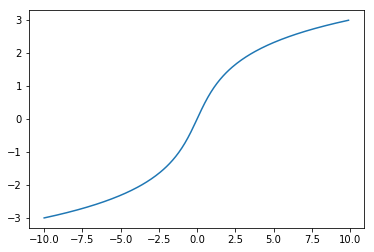

In [3]:
t1 = np.arange(-10.0, 10.0, 0.1)
t2 = np.arcsinh(t1)
plt.plot(t1,t2)

print np.arcsinh(10000000000000000000)

# Draw cuts with prior information
Data is now in a D dimensional cube, the goal it to find one optimal cut in each dimension

In [4]:
def draw_informed_cuts(theta_space, table):
    """
    INPUT: table: a K*D DataFrame of +-1 knowledge
    OUTPUT: np.array of lenght D, cuts on each dimension 
    """
    # return a list of cuts 
    # INFORMATIVE PRIORS
    upper_cut = (5., 1.)
    lower_cut = (1., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (1., 1.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut
                  }
    
    headers = list(table)
    
    matching_prior_info = [np.unique(table[_]) for _ in headers]
    prior_type_str = [' '.join([str(int(x)) for x in _ ]) for _ in matching_prior_info]
    prior_params = [priors_dict[_] for _ in prior_type_str]
    
    cuts = [(theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[d][0], prior_params[d][1]) 
            for d in range(len(headers))]
    return cuts

In [5]:
def count_points_per_box(data,cuts):
    """
    INPUT: 
    data : N*D np.array
    cuts: np.array of lenght D, cuts on each dimension
    OUTPUT:
    D folds of lists: number of data points in each box
    """
    D = len(cuts)
    idx_left = data[:,0] < cuts[0]
    idx_right = data[:,0] >= cuts[0]
    
    if D == 1:
        return [idx_left.sum(),idx_right.sum()]
    
    return [count_points_per_box(data[idx_left,1:],cuts[1:]),count_points_per_box(data[idx_right,1:],cuts[1:])]

def comp_size_per_box(theta_space, cuts):
    """
    INPUT: 
    theta_space : D*2 np.array, min and max of each dimension
    cuts: np.array of lenght D, cuts on each dimension
    OUTPUT:
    D folds of lists: size of each box
    """
    D = len(cuts)
    len_left = cuts[0] - theta_space[0,0]
    len_right = theta_space[0,1] - cuts[0]
    if D == 1:
        return [len_left, len_right]
    
    return [[len_left+ _ for _ in comp_size_per_box(theta_space[1:,], cuts[1:])],
           [len_right+_ for _ in comp_size_per_box(theta_space[1:,], cuts[1:])]]

def comp_log_p_sample(theta_space, data, cuts):
    counts = np.array(count_points_per_box(data, cuts))
    sizes = np.array(comp_size_per_box(theta_space, cuts))
    return -(counts * np.log(sizes)).sum()    

# Fit model to 2 dimensional data and visualize

In [6]:
data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
table_2d = table[['CD4','CD8']]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()

theta_space = np.array([[x_min, x_max], [y_min, y_max]])

(1000, 2)


In [7]:
n_mcmc_chain = 5
n_mcmc_sample = 10000
mcmc_gaussin_std = 0.05 # tune step size s.t. acceptance rate ~50%

accepts = []
rejects = []


for chain in range(n_mcmc_chain):
    
    print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_cuts(theta_space, table_2d)
    log_p_sample = comp_log_p_sample(theta_space, data_2d, sample)
    
    accepts.append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        # propose a new sample under gaussian distribution
        good_sample = False
        while good_sample == False:
            new_sample = np.random.normal(0, mcmc_gaussin_std, 2) + sample
            if (new_sample > theta_space[:,0]).all() and (new_sample < theta_space[:,1]).all():
                good_sample = True
                
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(theta_space, data_2d, new_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects.append(new_sample)
        
        else:
                sample = new_sample
                log_p_sample = new_log_p_sample
                accepts.append(sample)
        

        if (idx+1) % 10000 == 0:
            print "Iteration %d, Samples %d" %(idx+1, len(accepts))

    print "Number of samples collected: %d" %(len(accepts))

Drawing Chain 0 ...
Iteration 10000, Samples 529
Number of samples collected: 529
Drawing Chain 1 ...
Iteration 10000, Samples 986
Number of samples collected: 986
Drawing Chain 2 ...
Iteration 10000, Samples 1423
Number of samples collected: 1423
Drawing Chain 3 ...
Iteration 10000, Samples 1881
Number of samples collected: 1881
Drawing Chain 4 ...
Iteration 10000, Samples 2436
Number of samples collected: 2436


to-do: burn-in and thinning ...

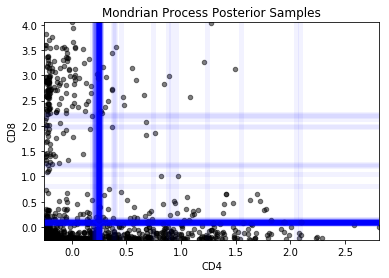

In [8]:
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(theta_space, data, list_of_cuts , trans_level=.05, color='k'):
    plt.figure()    
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=20, alpha=.5)

    for cuts in list_of_cuts:
        plt.plot([cuts[0], cuts[0]], [theta_space[1,0], theta_space[1,1]], color+'-', linewidth=5, alpha=trans_level)  
        plt.plot([theta_space[0,0], theta_space[0,1]], [cuts[1], cuts[1]], color+'-', linewidth=5, alpha=trans_level)  

np.random.shuffle(accepts)
print_posterior(theta_space, data_2d, accepts[:100] , trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

# Fit model to 32 dimensional AML data

In [9]:
# input data: data, table
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])

In [ ]:
%%time

n_mcmc_chain = 5
n_mcmc_sample = 10
mcmc_gaussin_std = 0.05 # tune step size s.t. acceptance rate ~50%
batch_size = 1000

accepts = []
rejects = []


for chain in range(n_mcmc_chain):
    
    print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_cuts(theta_space, table)
    log_p_sample = comp_log_p_sample(theta_space, data[np.random.randint(data.shape[0], size=batch_size), :], sample)
    
    print "fjdaklfjda"
    
    accepts.append(sample)
    
    print ",mmmmm"
    for idx in xrange(n_mcmc_sample):
        
        # propose a new sample under gaussian distribution
        good_sample = False
        while good_sample == False:
            new_sample = np.random.normal(0, mcmc_gaussin_std, 2) + sample
            if [(new_sample > theta_space[:,d]).all() for d in range(data.shape[1])].all():
                good_sample = True
        
        print ",,,,,,"
        
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(theta_space, data[np.random.randint(data.shape[0], size=batch_size), :], new_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects.append(new_sample)
        
        else:
                sample = new_sample
                log_p_sample = new_log_p_sample
                accepts.append(sample)
        

        if (idx+1) % 1000 == 0:
            print "Iteration %d, Samples %d" %(idx+1, len(accepts))

    print "Number of samples collected: %d" %(len(accepts))

Drawing Chain 0 ...
